In [1]:
import rasterio
import numpy as np

# Replace with your actual file path
file_path = "output_SRTMGL1.tif"

with rasterio.open(file_path) as dataset:
    elevation = dataset.read(1)  # Read first band
    print("Shape:", elevation.shape)
    print("Min elevation:", np.min(elevation))
    print("Max elevation:", np.max(elevation))


Shape: (30, 46)
Min elevation: 291
Max elevation: 308


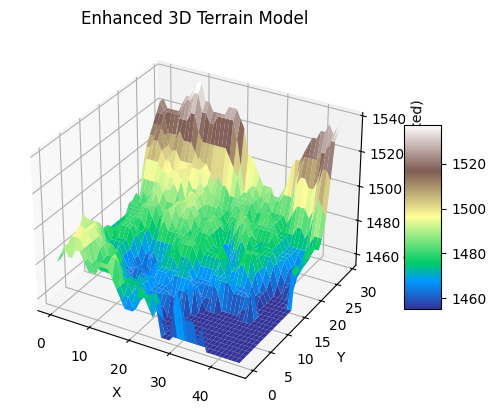

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

file_path = "output_SRTMGL1.tif"

with rasterio.open(file_path) as dataset:
    elevation = dataset.read(1)

# Vertical exaggeration (important!)
elevation = elevation * 5  

x = np.arange(elevation.shape[1])
y = np.arange(elevation.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    x, y, elevation,
    cmap='terrain',
    edgecolor='none'
)

fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title("Enhanced 3D Terrain Model")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation (exaggerated)")

plt.show()


#### details for a pixel in above data

In [3]:
import rasterio
file_path = "output_SRTMGL1.tif"


with rasterio.open(file_path) as dataset:
    elevation = dataset.read(1)
    
    print("CRS:", dataset.crs)
    print("Transform:", dataset.transform)
    print("Pixel size:", dataset.res)
    
    # Example: pixel at row 5, column 5
    row, col = 5, 5
    value = elevation[row, col]
    
    lon, lat = dataset.xy(row, col)
    
    print("Pixel value (Elevation):", value)
    print("Latitude:", lat)
    print("Longitude:", lon)


CRS: EPSG:4326
Transform: | 0.00, 0.00, 79.19|
| 0.00,-0.00, 21.00|
| 0.00, 0.00, 1.00|
Pixel size: (0.0002777777777778146, 0.0002777777777778146)
Pixel value (Elevation): 299
Latitude: 20.99527777777261
Longitude: 79.19611111114547


## details of our DEM Model data

In [4]:
import rasterio

file_path = "output_SRTMGL1.tif"

with rasterio.open(file_path) as dataset:
    bounds = dataset.bounds
    crs = dataset.crs
    
    print("CRS:", crs)
    print("Bounding Box:")
    print("Left (min lon):", bounds.left)
    print("Right (max lon):", bounds.right)
    print("Bottom (min lat):", bounds.bottom)
    print("Top (max lat):", bounds.top)


CRS: EPSG:4326
Bounding Box:
Left (min lon): 79.19458333336769
Right (max lon): 79.20736111114547
Bottom (min lat): 20.988472222217055
Top (max lat): 20.996805555550388


### Comparing DEM AND DSM data for same area 


In [5]:
import rasterio

dem_path = "output_SRTMGL1.tif"
dsm_path = "output_AW3D30.tif"

with rasterio.open(dem_path) as dem:
    print("DEM shape:", dem.shape)
    print("DEM CRS:", dem.crs)
    print("DEM resolution:", dem.res)
    print("DEM bounds:", dem.bounds)

print("\n------------------\n")

with rasterio.open(dsm_path) as dsm:
    print("DSM shape:", dsm.shape)
    print("DSM CRS:", dsm.crs)
    print("DSM resolution:", dsm.res)
    print("DSM bounds:", dsm.bounds)


DEM shape: (30, 46)
DEM CRS: EPSG:4326
DEM resolution: (0.0002777777777778146, 0.0002777777777778146)
DEM bounds: BoundingBox(left=79.19458333336769, bottom=20.988472222217055, right=79.20736111114547, top=20.996805555550388)

------------------

DSM shape: (30, 46)
DSM CRS: EPSG:4326
DSM resolution: (0.0002777777777778173, 0.0002777777777778173)
DSM bounds: BoundingBox(left=79.19444444448095, bottom=20.988611111102145, right=79.20722222225874, top=20.996944444435478)


In [6]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

dem_path = "output_SRTMGL1.tif"
dsm_path = "output_AW3D30.tif"

with rasterio.open(dem_path) as dem:
    dem_data = dem.read(1)
    dem_transform = dem.transform
    dem_crs = dem.crs
    dem_shape = dem.shape

with rasterio.open(dsm_path) as dsm:
    dsm_data = dsm.read(1)

# Create empty array to hold aligned DSM
aligned_dsm = np.empty(dem_shape, dtype=np.float32)

reproject(
    source=dsm_data,
    destination=aligned_dsm,
    src_transform=dsm.transform,
    src_crs=dsm.crs,
    dst_transform=dem_transform,
    dst_crs=dem_crs,
    resampling=Resampling.bilinear
)

print("Alignment complete.")


Alignment complete.


## Compute Crop Height Model

In [7]:
crop_height = aligned_dsm - dem_data

print("Min height:", np.min(crop_height))
print("Max height:", np.max(crop_height))


Min height: -6.0
Max height: 2.25


### Visualize 2D Crop Height Map

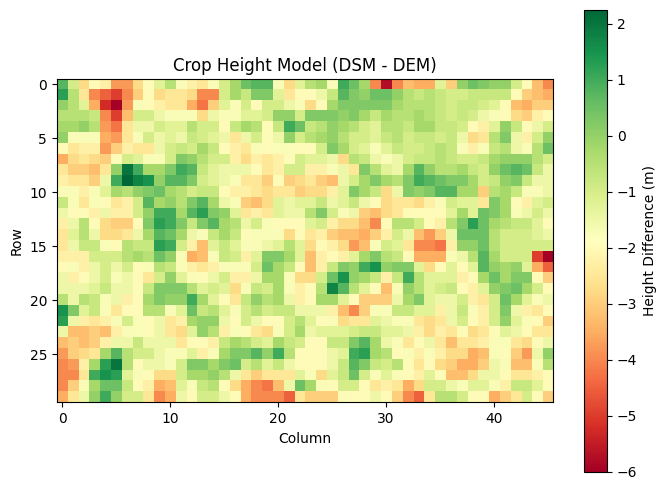

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(crop_height, cmap='RdYlGn')
plt.colorbar(label='Height Difference (m)')
plt.title("Crop Height Model (DSM - DEM)")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


### 3D Visualization of Crop Height

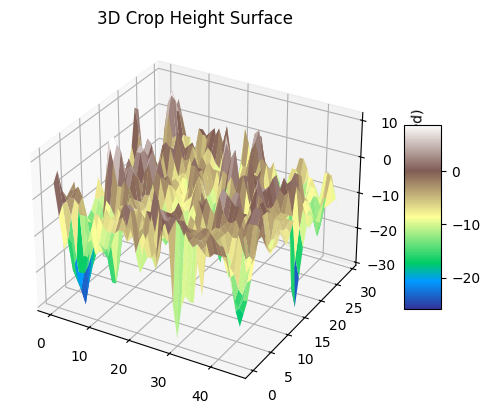

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Exaggerate vertically for better visibility
height_exaggerated = crop_height * 5

x = np.arange(height_exaggerated.shape[1])
y = np.arange(height_exaggerated.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    x, y, height_exaggerated,
    cmap='terrain',
    edgecolor='none'
)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("3D Crop Height Surface")
ax.set_zlabel("Height (Exaggerated)")

plt.show()


In [10]:
import plotly.graph_objects as go
import numpy as np

# Exaggerate height for visibility
height_exaggerated = crop_height * 5

rows, cols = height_exaggerated.shape
x = np.arange(cols)
y = np.arange(rows)

fig = go.Figure(data=[go.Surface(
    z=height_exaggerated,
    x=x,
    y=y,
    colorscale='Viridis',
    colorbar=dict(title='Height (Exaggerated)')
)])

fig.update_layout(
    title='Interactive 3D Crop Height',
    scene=dict(
        xaxis_title='Column',
        yaxis_title='Row',
        zaxis_title='Height (Exaggerated)'
    )
)

fig.show()


In [11]:
avg_height = np.mean(crop_height[crop_height > 0])
print("Average crop height (m):", avg_height)


Average crop height (m): 0.62333333


In [12]:
pixel_area = 30 * 30  # 30m x 30m
volume = np.sum(crop_height[crop_height > 0] * pixel_area)
print("Total crop volume (m³):", volume)


Total crop volume (m³): 84150.0


## complete 3D farm model

In [13]:
import rasterio
import numpy as np
import plotly.graph_objects as go
from rasterio.warp import reproject, Resampling

# -------------------------------
# Load DEM and DSM
# -------------------------------
dem_path = "output_SRTMGL1.tif"
dsm_path = "output_AW3D30.tif"

with rasterio.open(dem_path) as dem:
    dem_data = dem.read(1)
    dem_transform = dem.transform
    dem_crs = dem.crs
    dem_shape = dem.shape

with rasterio.open(dsm_path) as dsm:
    dsm_data = dsm.read(1)

# -------------------------------
# Align DSM to DEM grid
# -------------------------------
aligned_dsm = np.empty(dem_shape, dtype=np.float32)

reproject(
    source=dsm_data,
    destination=aligned_dsm,
    src_transform=dsm.transform,
    src_crs=dsm.crs,
    dst_transform=dem_transform,
    dst_crs=dem_crs,
    resampling=Resampling.bilinear
)

# -------------------------------
# Compute Crop Height Model (CHM)
# -------------------------------
crop_height = aligned_dsm - dem_data
crop_height[crop_height < 0] = 0  # Remove negative values

# -------------------------------
# Prepare grid
# -------------------------------
rows, cols = dem_shape
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)

# Vertical exaggeration
dem_exag = dem_data * 1
crop_exag = crop_height * 5
air_exag = dem_exag + crop_exag + 5

# -------------------------------
# Plot 3D Layers
# -------------------------------
fig = go.Figure()

# Ground Layer
fig.add_trace(go.Surface(
    z=dem_exag,
    x=x,
    y=y,
    colorscale='viridis',   # Plotly-compatible
    showscale=False,
    name='Ground'
))

# Crop Layer
fig.add_trace(go.Surface(
    z=dem_exag + crop_exag,
    x=x,
    y=y,
    colorscale='greens',
    opacity=0.7,
    showscale=True,
    colorbar=dict(title='Crop Height (m)'),
    name='Crops'
))

# Air / Environment Layer
fig.add_trace(go.Surface(
    z=air_exag + 5,
    x=x,
    y=y,
    colorscale='blues',
    opacity=0.3,
    showscale=False,
    name='Air / Clouds'
))

# Layout
fig.update_layout(
    title='3D Farm Model: Ground + Crops + Environment',
    scene=dict(
        xaxis_title='X (Columns)',
        yaxis_title='Y (Rows)',
        zaxis_title='Height (m)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1)
        )
    ),
    width=900,
    height=700
)

fig.show()

# -------------------------------
# Optional Analysis
# -------------------------------
pixel_area = 30 * 30  # meters² per pixel
total_volume = np.sum(crop_height * pixel_area)
avg_height = np.mean(crop_height[crop_height > 0])

print(f"Average crop height (m): {avg_height:.2f}")
print(f"Total crop volume (m³): {total_volume:.1f}")


Average crop height (m): 0.62
Total crop volume (m³): 84150.0
